<a href="https://colab.research.google.com/github/osilian/ml4sc-project/blob/master/identification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementation of RNN Structure for model Identification


cuda


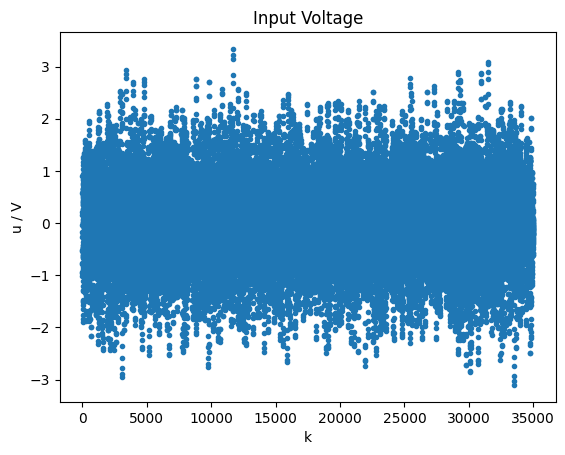

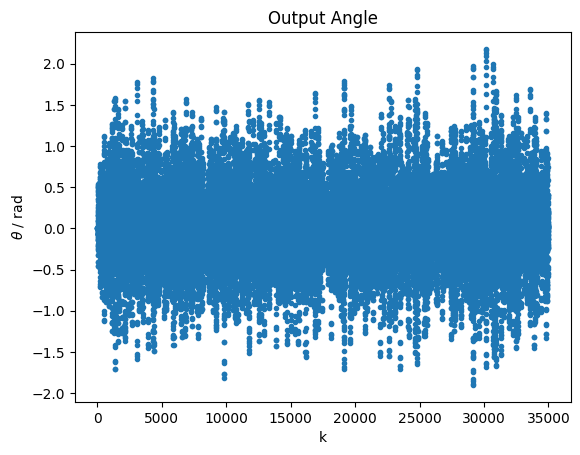

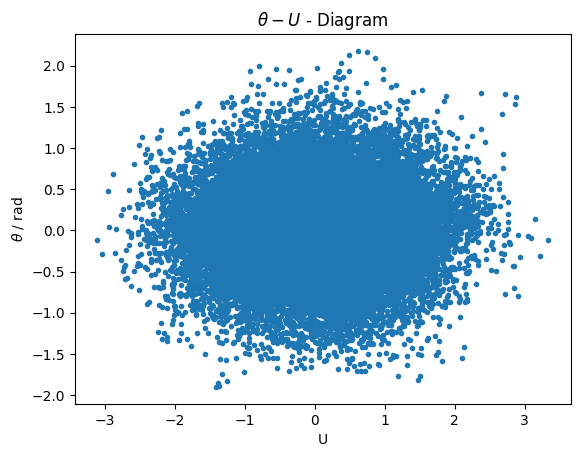

In [ ]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...

# Plot Data
plt.plot(u_data,'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(th_data,'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(u_data,th_data,'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


def create_IO_data(u,y):
    X = []
    Y = []
    for k in range(1, len(y)):
        X.append(np.stack([u[k-1], y[k-1]], axis=0))
        Y.append(y[k])
    return np.array(X), np.array(Y)

def create_timeseries_data(udata=u_data, ydata=th_data, testSize=0.2):
    # split into training in validation data
    from sklearn import model_selection
    u_train, u_val, y_train, y_val= model_selection.train_test_split(udata, ydata, shuffle=False, test_size=testSize,random_state=42)
    Xtrain, Ytrain = create_IO_data(u_train,y_train)
    Xval, Yval = create_IO_data(u_val,y_val)
    Xtrain, Xval, Ytrain, Yval = [torch.as_tensor(x,dtype=torch.float32, device=device).unsqueeze(0) for x in [Xtrain, Xval, Ytrain, Yval]] #convert it to torch arrays
    return Xtrain, Xval, Ytrain, Yval


## Model Parameters

In [ ]:
na, nb = 2,2
n_hidden_nodes = 10

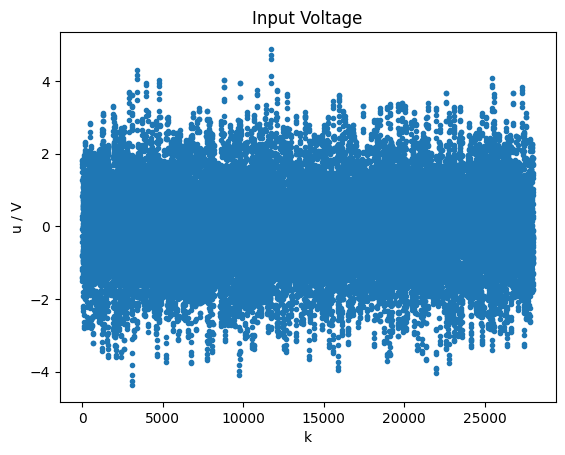

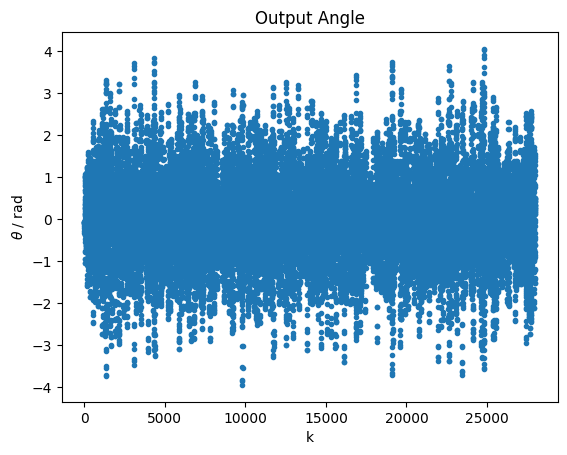

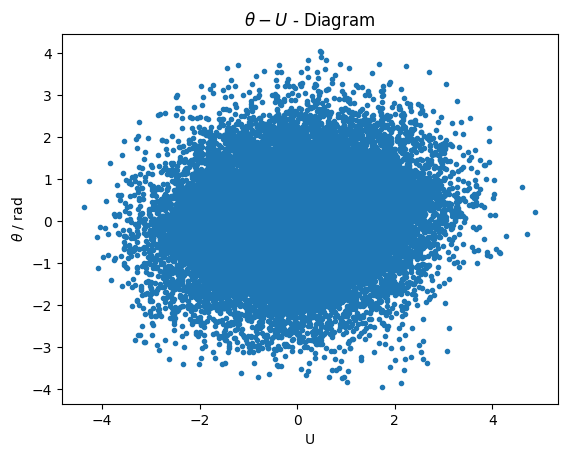

In [ ]:
# Normalization
Xtrain, Xval, Ytrain, Yval = create_timeseries_data()

x_train_mean = torch.mean(Xtrain).item()
x_train_std = torch.std(Xtrain).item()
y_train_mean = torch.mean(Ytrain).item()
y_train_std = torch.std(Ytrain).item()
class dataNormalization():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def normalize(self, XData, YData):
        #Xnorm = 2 * (XData - self.x_min) / (self.x_max - self.x_min) - 1 # -1 and * 2 to always normalize into (-1,1) no matter what the smallest x_min is
        #Ynorm = 2 * (YData - self.y_min) / (self.y_max - self.y_min) - 1
        Xnorm = (XData-x_train_mean)/x_train_std
        Ynorm = (YData-y_train_mean)/y_train_std
        #Xnorm = XData
        #Ynorm = YData
        return Xnorm, Ynorm

    def denormalize(self, YData_norm):
        #YData = 0.5 * (YData_norm + 1) * (self.y_max - self.y_min) + self.y_min
        YData = YData_norm*y_train_std + y_train_mean
        #YData = YData_norm
        return YData
x_min = -3 #torch.min(torch.min(Xtrain)).item()
x_max = +3 #torch.max(torch.min(Xtrain)).item()
y_min = -2/3*np.pi  #torch.min(torch.min(Ytrain)).item()
y_max = +2/3*np.pi   #torch.max(torch.min(Ytrain)).item()
dataNorm = dataNormalization(x_min,x_max,y_min,y_max)

Xtrain_norm, Ytrain_norm = dataNorm.normalize(Xtrain, Ytrain)

# Plot Data
plt.plot(Xtrain_norm.squeeze(0).cpu()[:,0],'.')
plt.title('Input Voltage')
plt.xlabel('k')
plt.ylabel('u / V')
plt.show()

plt.plot(Ytrain_norm.squeeze(0).cpu(),'.')
plt.title('Output Angle')
plt.xlabel('k')
plt.ylabel(r'$\theta$ / rad')
plt.show()

plt.plot(Xtrain_norm.squeeze(0).cpu()[:,0],Ytrain_norm.squeeze(0).cpu(),'.')
plt.title(r'$\theta - U$ - Diagram')
plt.xlabel('U')
plt.ylabel(r'$\theta$ / rad')
plt.show()


## Network Definition

In [ ]:
class rnnNetwork(nn.Module):
    def __init__(self, n_in, n_hidden_nodes,activation="tanh"): #a)
        super(rnnNetwork,self).__init__() #a)
        #self.lay1 = nn.Linear(n_in,n_hidden_nodes).double() #a)
        #self.lay2 = nn.Linear(n_hidden_nodes,1).double() #a)

        self.rnnLayer = nn.RNN(input_size=n_in,hidden_size=n_hidden_nodes,
                               nonlinearity=activation, batch_first=True)
        self.linLayer = nn.Linear(n_hidden_nodes,1)


    def forward(self,x): #a)
        #x = [batch_size, seq_length, input_size], [u_k-1 y_k-1]
        x1,h1 = self.rnnLayer(x)
        y = self.linLayer(x1[:, -1, :])
        return y #a)

In [ ]:
#n_hidden_nodes = 2 #a)
model = rnnNetwork(2, n_hidden_nodes,activation='tanh')
model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training

epochs = 10*10**3 #a)
for epoch in range(epochs): #a)
    model.train()
    Loss = torch.mean((model(Xtrain_norm)-Ytrain_norm)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if epoch%100==0: #a) monitor
        print(epoch,Loss.item()) #a)

model.eval()

0 1.1478490829467773
100 0.9999706149101257
200 0.9999642372131348
300 0.9999642372131348
400 0.9999642372131348
500 0.9999642372131348
600 0.9999642372131348
700 0.9999642372131348
800 0.9999642372131348
900 0.9999642372131348
1000 0.9999642372131348
1100 0.9999642372131348
1200 0.9999642372131348
1300 0.9999642372131348
1400 0.9999642372131348
1500 0.9999642372131348
1600 0.9999642372131348
1700 0.9999642372131348
1800 0.9999642372131348
1900 0.9999642372131348
2000 0.9999642372131348
2100 0.9999642372131348
2200 0.9999642372131348
2300 0.9999642372131348
2400 0.9999642372131348
2500 0.9999642372131348
2600 0.9999642372131348
2700 0.9999642372131348
2800 0.9999642372131348
2900 0.9999642372131348
3000 0.9999642372131348
3100 0.9999642372131348
3200 0.9999642372131348
3300 0.9999642372131348
3400 0.9999642372131348


KeyboardInterrupt: 

In [ ]:
print(epoch,Loss.item())

train prediction errors:
RMS: tensor(0.4695, device='cuda:0') radians
RMS: tensor(26.8982, device='cuda:0') degrees
NRMS: tensor(99.9982, device='cuda:0') %


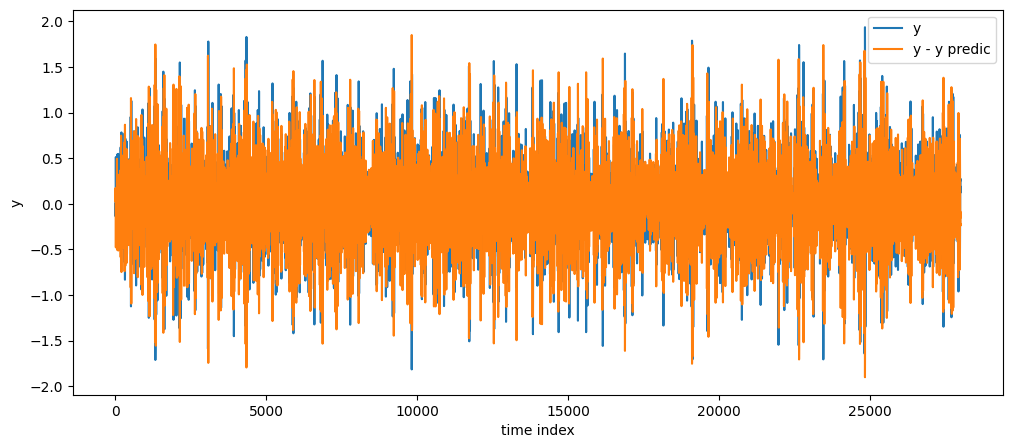

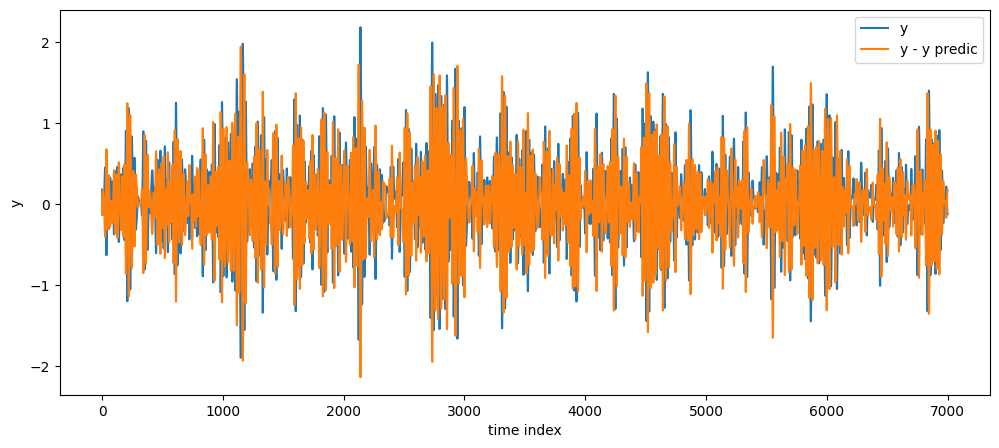

validation prediction errors:
RMS: tensor(0.5170, device='cuda:0') radians
RMS: tensor(29.6245, device='cuda:0') degrees
NRMS: tensor(99.9983, device='cuda:0') %


In [ ]:
#residual calculations and plotting
with torch.no_grad():
    Ytrain = Ytrain.squeeze(0)
    Ytrain_pred_norm = model(Xtrain_norm).squeeze(0)
    Ytrain_pred = dataNorm.denormalize(YData_norm=Ytrain_pred_norm)
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/Ytrain.std()*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)

    Yval = Yval.squeeze(0)
    Xval_norm, _ = dataNorm.normalize(XData=Xval, YData=Yval)
    Yval_pred_norm = model(Xval_norm).squeeze(0)
    Yval_pred = dataNorm.denormalize(Yval_pred_norm)
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2)**0.5/Yval.std()*100,'%')